# This notebook is used to only work with saved data and test with several models
    Enrique Posada Lozano

#### Import required libraries

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import time

#### Declaration of constants from where to OBTAIN data

In [2]:
PREICTAL_DURATION = 10
SUBWINDOW_DURATION = 60
# PREICTAL_DURATION = 5
# SUBWINDOW_DURATION = 30
NUM_TIMESTEPS = 12
# SUBWINDOW_DURATION = 60
# NUM_TIMESTEPS = 12 # number of timesteps to resize
    # TIMESTEP_SIZE = SUBWINDOW_DURATION//DURATION_PER_TIMESTEP # SUBWINDOW/DURATION_PER_TIMESTEP
PATH = 'data/'+('_'+str(PREICTAL_DURATION)+'minPreictal')+('/_'+str(SUBWINDOW_DURATION)+'s/')+('_'+str(NUM_TIMESTEPS)+'ts/')
    # PATH = 'data/'+('_'+str(PREICTAL_DURATION)+'minPreictal')+('/_'+str(SUBWINDOW_DURATION)+'s/')+('_'+str(NUM_TIMESTEPS)+'ts/')+'FP1-F7'+'/' # obtaining data saved from one channel
    # ANN PATH
# PATH = 'data/'+('_'+str(PREICTAL_DURATION)+'minPreictal')+('/_'+str(SUBWINDOW_DURATION)+'s/')+'_ANN/'

# DURATION_PER_TIMESTEP = 5
# PATH = 'data/'+('_'+str(PREICTAL_DURATION)+'minPreictal')+('/_'+str(SUBWINDOW_DURATION)+'s/') # for obtaining all data features/labels (not in train format)

#### Declaration of Functions

In [3]:
def balanceClasses(features,labels,sampling):
    """
        Balances the interictal and preictal classes by looking for the class with least amount of data, and randomly choosing segments from the other class in order to balance the class dataset
        Input:
            Receieves the preictal and interictal indexes \n
            sampling receives either "undersampling" or "oversampling" as parameter in order to determine the process to execute
        Output:
            returns a numpy array containing the indexes of both preictal and interictal data
    """
    samplingParams = set(("undersampling","oversampling"))
    if not sampling in samplingParams: raise ValueError("sampling PARAM must be either 'undersampling' or 'oversampling'")
    interictal_indexes = np.array(np.where(labels == 0))[0]
    preictal_indexes = np.array(np.where(labels == 1))[0]
    print("___Original Data Length___")
    print("Preictal \t:\t",preictal_indexes.shape)
    print("Interictal \t:\t",interictal_indexes.shape)
    print("\n")
    if sampling == "undersampling":
        if len(preictal_indexes) > len(interictal_indexes):
            # if there are more preictal segments, randomly choose segments to balance dataset
            preictal_indexes = np.random.choice(preictal_indexes,len(interictal_indexes),replace=False)
        else:
            # randomly choose interictal segments to balance the dataset
            interictal_indexes = np.random.choice(interictal_indexes,len(preictal_indexes),replace=False)
    else:
        if len(preictal_indexes) < len(interictal_indexes):
            # if there are less preictal segments, randomly choose segments to balance dataset with more, repeated preictal data
            preictal_indexes = np.random.choice(preictal_indexes,len(interictal_indexes),replace=True)
        else:
            # randomly choose interictal segments to balance the dataset
            interictal_indexes = np.random.choice(interictal_indexes,len(preictal_indexes),replace=True)
    print("\n___Modified Shape___")
    print("Preictal \t:\t",preictal_indexes.shape)
    print("Interictal \t:\t",interictal_indexes.shape)
    indexes = np.concatenate((preictal_indexes,interictal_indexes)) # shuffles indexes in order to not have data in an organized manner
    # print(indexes)
    # print("Shuffling")
    np.random.shuffle(indexes)
    # print(indexes)
    # raise Exception(" NONE, just finished")
    print("Returning indexed data")
    startTime = time.time()
    indexedFeatures = features[indexes]
    print("Features obtained took "+str(round(time.time()-startTime))+" seconds")
    indexedLabels = labels[indexes]
    print("Class Label Count\t",np.unique(indexedLabels,return_counts=True))
    # print("\n\n")
    return indexedFeatures, indexedLabels

## 1. Training models using the saved train/val/test features and labels
### <ins>If you want to randomly sample from the dataset and obtain different training datasets, or balance classes in a different strategy, go to section #2</ins>

### Obtain training/validation/test features and labels

In [4]:
# Training Dataset
x_Train = np.load(PATH+"train_features.npy")
y_Train = np.load(PATH+"train_labels.npy")
print("Training data feature shape :\t",x_Train.shape)
print("Training data label shape :\t",y_Train.shape)
print("\n\n")

# Validation Dataset
x_Val = np.load(PATH+"val_features.npy")
y_Val = np.load(PATH+"val_labels.npy")
print("Validation data feature shape :\t",x_Val.shape)
print("Validation data label shape :\t",y_Val.shape)
print("\n\n")

# Test Dataset
x_Test = np.load(PATH+"test_features.npy")
y_Test = np.load(PATH+"test_labels.npy")
print("Testing data feature shape :\t",x_Test.shape)
print("Testing data label shape :\t",y_Test.shape)

Training data feature shape :	 (2539, 12, 23040)
Training data label shape :	 (2539,)



Validation data feature shape :	 (142, 12, 23040)
Validation data label shape :	 (142,)



Testing data feature shape :	 (141, 12, 23040)
Testing data label shape :	 (141,)


In [5]:
uniqueLabels, labelCounts = np.unique(y_Train,return_counts=True)
print("Unique Classes\t\t",uniqueLabels)
for index,label in enumerate(labelCounts):
    print("\tClass "+str(uniqueLabels[index])+" contains\t"+str(label))

Unique Classes		 [0. 1.]
	Class 0.0 contains	1018
	Class 1.0 contains	1521


#### Decide to balance the dataset by either a oversample strategy or undersample strategy

    Balance Train dataset by UNDERSAMPLING

In [6]:
x_Train,y_Train = balanceClasses(x_Train,y_Train,sampling="undersampling")

___Original Data Length___
Preictal 	:	 (1521,)
Interictal 	:	 (1018,)



___Modified Shape___
Preictal 	:	 (1018,)
Interictal 	:	 (1018,)
Returning indexed data
Features obtained took 16 seconds
Class Label Count	 (array([0., 1.]), array([1018, 1018]))


    Balance Train dataset by OVERSAMPLING

In [7]:
# x_Train,y_Train = balanceClasses(x_Train,y_Train,sampling="oversampling")

#### Balance Test and Val classes in order to validate the model classifying by undersampling to an equal number of segments

In [8]:
x_Test,y_Test = balanceClasses(x_Test,y_Test,sampling="undersampling")
x_Val,y_Val = balanceClasses(x_Val,y_Val,sampling="undersampling")

___Original Data Length___
Preictal 	:	 (85,)
Interictal 	:	 (56,)



___Modified Shape___
Preictal 	:	 (56,)
Interictal 	:	 (56,)
Returning indexed data
Features obtained took 0 seconds
Class Label Count	 (array([0., 1.]), array([56, 56]))
___Original Data Length___
Preictal 	:	 (85,)
Interictal 	:	 (57,)



___Modified Shape___
Preictal 	:	 (57,)
Interictal 	:	 (57,)
Returning indexed data
Features obtained took 1 seconds
Class Label Count	 (array([0., 1.]), array([57, 57]))


#### Feature and Label Shapes

In [9]:
# Training Dataset
print("Final Training data feature shape :\t",x_Train.shape)
print("Final Training data label shape :\t",y_Train.shape)
print("\n\n")

# Validation Dataset
print("Final Validation data feature shape :\t",x_Val.shape)
print("Final Validation data label shape :\t",y_Val.shape)
print("\n\n")

# Test Dataset
print("Final Testing data feature shape :\t",x_Test.shape)
print("Final Testing data label shape :\t",y_Test.shape)

Final Training data feature shape :	 (2036, 12, 23040)
Final Training data label shape :	 (2036,)



Final Validation data feature shape :	 (114, 12, 23040)
Final Validation data label shape :	 (114,)



Final Testing data feature shape :	 (112, 12, 23040)
Final Testing data label shape :	 (112,)


## 2. Training models using different/random training data, if not then skip towards section #3

#### Obtain data features and labels

In [81]:
# allDataFeatures = np.load("data_features.npy")
# allDataLabels = np.load("data_labels.npy")
# print("Data feature shape :\t",allDataFeatures.shape)
# print("Data label shape :\t",allDataLabels.shape)
# TODO EXTRACT TRAINING DATA INSTEAD OF REPEATING THE PROCESS

#### Count number of elements per class

In [ ]:
uniqueLabels, labelCounts = np.unique(np.array(allDataLabels),return_counts=True)
print("Unique Classes\t\t",uniqueLabels)
for index,label in enumerate(labelCounts):
    print("\tClass "+str(uniqueLabels[index])+" contains\t"+str(label))

#### Reshape Data

In [11]:
dataFeatures = dataFeatures.reshape(-1,TIMESTEP_SIZE,NUM_CHANNELS*DURATION_PER_TIMESTEP*SAMPLING_RATE)

NameError: name 'dataFeatures' is not defined

## 3. DL Models

In [10]:
# Callback to control validation loss on training
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=8) # 8 epochs with no change to stop training

#### 1-layer LSTM

In [11]:
_1_layer_model = tf.keras.models.Sequential()

# _1_layer_model.add(tf.keras.layers.LSTM(units=80,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=False,kernel_regularizer=tf.keras.regularizers.l2(0.01),recurrent_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)))
_1_layer_model.add(tf.keras.layers.LSTM(units=32,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=False))
# _1_layer_model.add(tf.keras.layers.LayerNormalization())
# _1_layer_model.add(tf.keras.layers.Dropout(0.5))
# _1_layer_model.add(tf.keras.layers.BatchNormalization())

_1_layer_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
_1_layer_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# show _1_layer_model summary
_1_layer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                2953344   
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,953,377
Trainable params: 2,953,377
Non-trainable params: 0
_________________________________________________________________


In [12]:
# _1_layer_model.fit(x_Train,y_Train,epochs=10,batch_size=32)
_1_layer_model.fit(x_Train,y_Train,epochs=30,batch_size=128,validation_data=(x_Val,y_Val),callbacks=[callback])

Train on 2036 samples, validate on 114 samples
Epoch 1/30
2036/2036 [==============================] - 11s 5ms/sample - loss: 0.6934 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6930 - accuracy: 0.5108 - val_loss: 0.6931 - val_accuracy: 0.5175
Epoch 4/30
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6929 - accuracy: 0.5545 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
2036/2036 [==============================] - 7s 3ms/sample - loss: 0.6928 - accuracy: 0.4995 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/30
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6927 - accuracy: 0.4980 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/30
2036/2036 [==============================] - 7s 4ms/sample - loss

KeyboardInterrupt: 

##### Model Accuracy

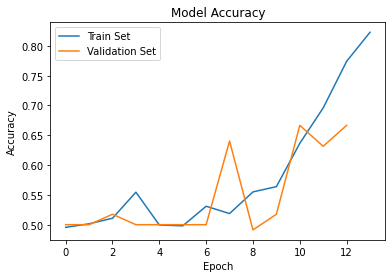

In [31]:
plot.plot(_1_layer_model.history.history['accuracy'])
plot.plot(_1_layer_model.history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()
# _1_layer_model.history.history

##### Model Loss

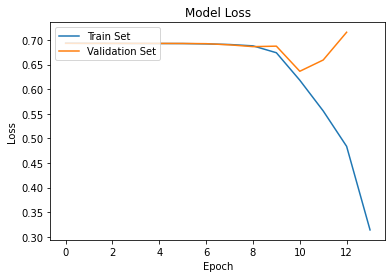

In [32]:
plot.plot(_1_layer_model.history.history['loss'])
plot.plot(_1_layer_model.history.history['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Results

In [33]:
print("Validation acc set at\t",_1_layer_model.evaluate(x_Val,y_Val))
print("Test acc set at\t",_1_layer_model.evaluate(x_Test,y_Test))
_1_layer_model_predictions = _1_layer_model.predict(x_Test)
np.unique((_1_layer_model_predictions.round() == y_Test),return_counts=True)

114/114 [==============================] - 0s 3ms/sample - loss: 0.7427 - accuracy: 0.6667
Validation acc set at	 [0.7427042257367519, 0.6666667]
112/112 [==============================] - 0s 3ms/sample - loss: 0.7366 - accuracy: 0.6518
Test acc set at	 [0.736574228320803, 0.65178573]


(array([False,  True]), array([6272, 6272]))

___1-Layer LSTM Results___


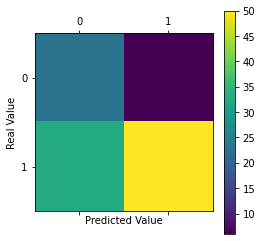

CM
 [[23  6]
 [33 50]]

Model Accuracy	:	 65.18%
Sensitivity	:	 60.24%
Specificity	:	 79.31%


In [34]:
print("___1-Layer LSTM Results___")
cm = confusion_matrix(_1_layer_model_predictions.round(),y_Test)
plot.matshow(cm)
# plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# _1_layer_model_predictions.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,_1_layer_model_predictions.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)


#### Save the model

In [61]:
_1_layer_model.save('models/_1_layer_lstm')

INFO:tensorflow:Assets written to: models/_1_layer_lstm/assets


#### 2-layer LSTM

In [15]:
_2_layer_model = tf.keras.models.Sequential()

_2_layer_model.add(tf.keras.layers.LSTM(units=32,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True))
# _2_layer_model.add(tf.keras.layers.LSTM(units=32,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.0001),recurrent_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001)))

# _2_layer_model.add(tf.keras.layers.Dropout(0.1))

# _2_layer_model.add(tf.keras.layers.LSTM(units=64)) # best experiment was using 0.2
_2_layer_model.add(tf.keras.layers.LSTM(units=64)) # best experiment was using 0.2
# _2_layer_model.add(tf.keras.layers.Dropout(0.1)) # not useful
# _2_layer_model.add(tf.keras.layers.Dropout(0.2))

# _2_layer_model.add(tf.keras.layers.Dense(units=128,activation='relu'))
# _2_layer_model.add(tf.keras.layers.Dense(units=32,activation='relu'))


_2_layer_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid')) # another experiment could be using sigmoid 
_2_layer_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) #using nadam just like stackoverflow

# show _2_layer_model summary
_2_layer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 32)            2953344   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,978,241
Trainable params: 2,978,241
Non-trainable params: 0
_________________________________________________________________


In [16]:
# _2_layer_history = _2_layer_model.fit(x_Train,y_Train,epochs=30,batch_size=128,validation_data=(x_Val,y_Val))
_2_layer_model.fit(x_Train,y_Train,epochs=60,batch_size=128,validation_data=(x_Val,y_Val),callbacks=[callback])

Train on 2036 samples, validate on 114 samples
Epoch 1/60
2036/2036 [==============================] - 25s 12ms/sample - loss: 0.6934 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/60
2036/2036 [==============================] - 8s 4ms/sample - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/60
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/60
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/60
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/60
2036/2036 [==============================] - 7s 4ms/sample - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/60
2036/2036 [==============================] - 7s 4ms/sample - los

KeyboardInterrupt: 

##### Model Accuracy

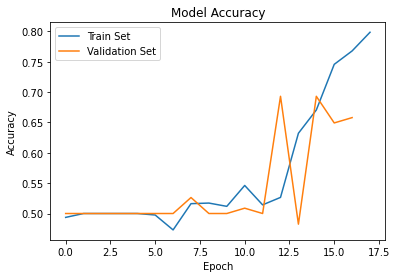

In [35]:
plot.plot(_2_layer_model.history.history['accuracy'])
plot.plot(_2_layer_model.history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Model Loss

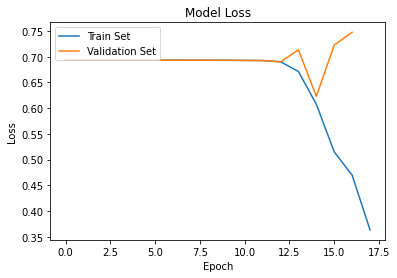

In [36]:
plot.plot(_2_layer_model.history.history['loss'])
plot.plot(_2_layer_model.history.history['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Results

In [37]:
print("Validation acc set at\t",_2_layer_model.evaluate(x_Val,y_Val))
print("Test acc set at\t",_2_layer_model.evaluate(x_Test,y_Test))
_2_layer_model_predictions = _2_layer_model.predict(x_Test)
np.unique((_2_layer_model_predictions.round() == y_Test),return_counts=True)

114/114 [==============================] - 0s 3ms/sample - loss: 0.7628 - accuracy: 0.6228
Validation acc set at	 [0.7627953808558615, 0.622807]
112/112 [==============================] - 0s 3ms/sample - loss: 0.7229 - accuracy: 0.6518
Test acc set at	 [0.7229273234094892, 0.65178573]


(array([False,  True]), array([6272, 6272]))

___2-Layer LSTM Results___


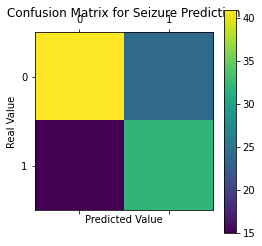

CM
 [[41 24]
 [15 32]]

Model Accuracy	:	 65.18%
Sensitivity	:	 68.09%
Specificity	:	 63.08%


In [38]:
print("___2-Layer LSTM Results___")
cm = confusion_matrix(_2_layer_model_predictions.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# _2_layer_model_predictions.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,_2_layer_model_predictions.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)


#### 3-layer LSTM (testing model depth approach against height "meaning less nodes per layer")

In [19]:
_3_layer_model = tf.keras.models.Sequential()

_3_layer_model.add(tf.keras.layers.LSTM(units=64,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True))

# _3_layer_model.add(tf.keras.layers.LayerNormalization())

# _3_layer_model.add(tf.keras.layers.Dropout(0.5))

_3_layer_model.add(tf.keras.layers.LSTM(units=64,return_sequences=True))
# _3_layer_model.add(tf.keras.layers.Dropout(0.5))

_3_layer_model.add(tf.keras.layers.LSTM(units=64,recurrent_dropout=0.2)) # ,recurrent_dropout=0.2
_3_layer_model.add(tf.keras.layers.Dropout(0.2))
_3_layer_model.add(tf.keras.layers.Dense(units=128,activation='relu'))

_3_layer_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
_3_layer_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# show _3_layer_model summary
_3_layer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 64)            5914880   
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 5,989,377
Trainable params: 5,989,377
Non-trainable params: 0
____________________________________________

In [22]:
_3_layer_model.fit(x_Train,y_Train,epochs=60,batch_size=128,validation_data=(x_Val,y_Val),callbacks=[callback])

Train on 2036 samples, validate on 114 samples
Epoch 1/60
2036/2036 [==============================] - 10s 5ms/sample - loss: 0.6924 - accuracy: 0.5108 - val_loss: 0.6914 - val_accuracy: 0.4825
Epoch 2/60
2036/2036 [==============================] - 10s 5ms/sample - loss: 0.6675 - accuracy: 0.5658 - val_loss: 0.7226 - val_accuracy: 0.5088
Epoch 3/60
2036/2036 [==============================] - 10s 5ms/sample - loss: 0.7172 - accuracy: 0.5516 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/60
2036/2036 [==============================] - 10s 5ms/sample - loss: 0.6914 - accuracy: 0.5138 - val_loss: 0.6920 - val_accuracy: 0.5351
Epoch 5/60
2036/2036 [==============================] - 11s 5ms/sample - loss: 0.6889 - accuracy: 0.5432 - val_loss: 0.6904 - val_accuracy: 0.4825
Epoch 6/60
2036/2036 [==============================] - 11s 5ms/sample - loss: 0.6823 - accuracy: 0.5737 - val_loss: 0.6840 - val_accuracy: 0.5175
Epoch 7/60
2036/2036 [==============================] - 11s 5ms/sample 

KeyboardInterrupt: 

##### Model Accuracy

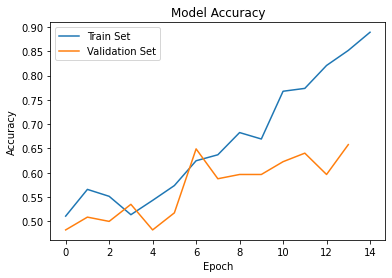

In [39]:
plot.plot(_3_layer_model.history.history['accuracy'])
plot.plot(_3_layer_model.history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Model Loss

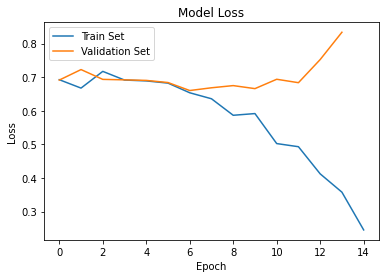

In [40]:
plot.plot(_3_layer_model.history.history['loss'])
plot.plot(_3_layer_model.history.history['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Results

In [41]:
print("Validation acc set at\t",_3_layer_model.evaluate(x_Val,y_Val))
print("Test acc set at\t",_3_layer_model.evaluate(x_Test,y_Test))
_3_layer_model_predictions = _3_layer_model.predict(x_Test)
np.unique((_3_layer_model_predictions.round() == y_Test),return_counts=True)

114/114 [==============================] - 0s 4ms/sample - loss: 0.8347 - accuracy: 0.6754
Validation acc set at	 [0.8346545319808157, 0.6754386]
112/112 [==============================] - 0s 3ms/sample - loss: 0.7556 - accuracy: 0.6607
Test acc set at	 [0.7556453602654594, 0.66071427]


(array([False,  True]), array([6272, 6272]))

___3-Layer LSTM Results___


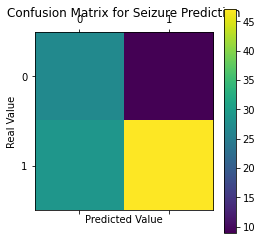

CM
 [[27  9]
 [29 47]]

Model Accuracy	:	 66.07%
Sensitivity	:	 61.84%
Specificity	:	 75.00%


In [42]:
print("___3-Layer LSTM Results___")
cm = confusion_matrix(_3_layer_model_predictions.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# _3_layer_model_predictions.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,_3_layer_model_predictions.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)


#### Save the model

In [15]:
_3_layer_model.save('models/_3_layer_lstm')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/_3_layer_lstm/assets


#### Replication of Kostas M. Tsiouris LSTM

In [25]:
print("Tsiouris Approach")
tsiouris_model = tf.keras.models.Sequential()
# adds an embedding layer expecting an input of size NUM_CHANNELS*SAMPLING_RATE*5_SEC_WINDOWS

tsiouris_model.add(tf.keras.layers.LSTM(units=128,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True))
# tsiouris_model.add(tf.keras.layers.BatchNormalization())
# tsiouris_model.add(tf.keras.layers.LSTM(units=128,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.001),recurrent_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001)))
# kernel_regularizer=tf.keras.regularizers.l2(0.0001),recurrent_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001)

tsiouris_model.add(tf.keras.layers.Dropout(0.2))

# tsiouris_model.add(tf.keras.layers.LSTM(units=128,kernel_regularizer=tf.keras.regularizers.l2(0.001),recurrent_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001)))
tsiouris_model.add(tf.keras.layers.LSTM(units=128))

tsiouris_model.add(tf.keras.layers.Dropout(0.2))

tsiouris_model.add(tf.keras.layers.Dense(units=32,activation='relu'))

tsiouris_model.add(tf.keras.layers.Dense(units=2,activation='softmax'))
# tsiouris_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

tsiouris_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# tsiouris_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# show tsiouris_model summary
tsiouris_model.summary()

Tsiouris Approach
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 128)           11862528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 11,998,306
Trainable params: 11,998,306
Non-trainable params: 0
________________________

In [26]:
tsiouris_model.fit(x_Train,y_Train,epochs=60,batch_size=128,validation_data=(x_Val,y_Val),callbacks=[callback])

Train on 2036 samples, validate on 114 samples
Epoch 1/60
2036/2036 [==============================] - 36s 18ms/sample - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/60
2036/2036 [==============================] - 14s 7ms/sample - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/60
2036/2036 [==============================] - 13s 7ms/sample - loss: 0.6933 - accuracy: 0.4823 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/60
2036/2036 [==============================] - 14s 7ms/sample - loss: 0.6933 - accuracy: 0.4833 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/60
2036/2036 [==============================] - 17s 8ms/sample - loss: 0.6935 - accuracy: 0.4882 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/60
2036/2036 [==============================] - 18s 9ms/sample - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/60
2036/2036 [==============================] - 17s 8ms/sample

##### Model Accuracy

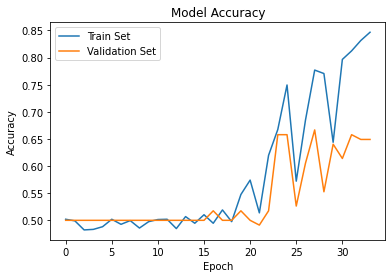

In [43]:
plot.plot(tsiouris_model.history.history['accuracy'])
plot.plot(tsiouris_model.history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Model Loss

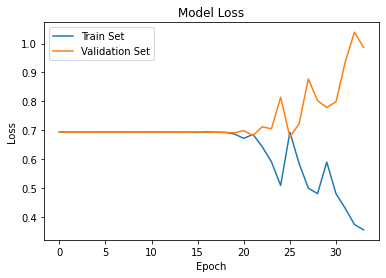

In [44]:
plot.plot(tsiouris_model.history.history['loss'])
plot.plot(tsiouris_model.history.history['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Results

In [45]:
print("Validation acc set at\t",tsiouris_model.evaluate(x_Val,y_Val))
print("Test acc set at\t",tsiouris_model.evaluate(x_Test,y_Test))
tsiouris_model_predictions = tsiouris_model.predict(x_Test)
np.unique((tsiouris_model_predictions.round() == y_Test),return_counts=True)

114/114 [==============================] - 1s 5ms/sample - loss: 0.9864 - accuracy: 0.6491
Validation acc set at	 [0.986407739028596, 0.64912283]
112/112 [==============================] - 1s 5ms/sample - loss: 1.0113 - accuracy: 0.6429
Test acc set at	 [1.0113469532557897, 0.64285713]
ipykernel_launcher:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(array([False]), array([1]))

In [46]:
tsiouris_model_predictions = np.argmax(tsiouris_model_predictions,axis=1)

___Tsiouris LSTM Results___


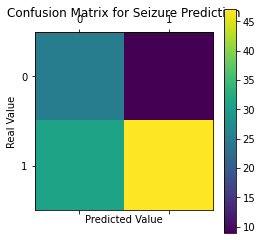

CM
 [[25  9]
 [31 47]]

Model Accuracy	:	 64.29%
Sensitivity	:	 60.26%
Specificity	:	 73.53%


In [47]:
print("___Tsiouris LSTM Results___")
cm = confusion_matrix(tsiouris_model_predictions.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# tsiouris_predictions_rounded.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,tsiouris_model_predictions.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)
 

#### Save the model

In [68]:
tsiouris_model.save('models/tsiouris_lstm')

INFO:tensorflow:Assets written to: models/tsiouris_lstm/assets


### ANN Testing

In [12]:
x_Train.shape

(7740, 276480)

In [21]:
print("ANN Approach")
ann_model = tf.keras.models.Sequential()
# adds an embedding layer expecting an input of size NUM_CHANNELS*SAMPLING_RATE*5_SEC_WINDOWS

ann_model.add(tf.keras.layers.Dense(units=128,input_shape=(x_Train.shape[1],),activation='relu'))
# ann_model.add(tf.keras.layers.BatchNormalization())
# ann_model.add(tf.keras.layers.LSTM(units=128,input_shape=(x_Train.shape[1],x_Train.shape[2]),return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.001),recurrent_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001)))
# kernel_regularizer=tf.keras.regularizers.l2(0.0001),recurrent_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001)

# ann_model.add(tf.keras.layers.Dropout(0.2))

# ann_model.add(tf.keras.layers.LSTM(units=128,kernel_regularizer=tf.keras.regularizers.l2(0.001),recurrent_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001)))
ann_model.add(tf.keras.layers.Dense(units=128,activation='relu'))

# ann_model.add(tf.keras.layers.Dropout(0.2))

ann_model.add(tf.keras.layers.Dense(units=32,activation='relu'))

ann_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
# ann_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

ann_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# ann_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# show ann_model summary
ann_model.summary()

ANN Approach
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               35389568  
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 35,410,241
Trainable params: 35,410,241
Non-trainable params: 0
_________________________________________________________________


In [22]:
ann_model.fit(x_Train,y_Train,epochs=60,batch_size=128,validation_data=(x_Val,y_Val),callbacks=[callback])

Train on 7740 samples, validate on 430 samples
Epoch 1/60
7740/7740 [==============================] - 222s 29ms/sample - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5907
Epoch 2/60
7740/7740 [==============================] - 277s 36ms/sample - loss: 0.6929 - accuracy: 0.5132 - val_loss: 0.6927 - val_accuracy: 0.4977
Epoch 3/60
7740/7740 [==============================] - 230s 30ms/sample - loss: 0.6759 - accuracy: 0.6111 - val_loss: 0.6714 - val_accuracy: 0.5977
Epoch 4/60
7740/7740 [==============================] - 229s 30ms/sample - loss: 0.4776 - accuracy: 0.8235 - val_loss: 0.6770 - val_accuracy: 0.6581
Epoch 5/60
7740/7740 [==============================] - 220s 28ms/sample - loss: 0.2249 - accuracy: 0.9301 - val_loss: 0.8172 - val_accuracy: 0.7023
Epoch 6/60
7740/7740 [==============================] - 216s 28ms/sample - loss: 0.1056 - accuracy: 0.9762 - val_loss: 0.9337 - val_accuracy: 0.7233
Epoch 7/60
2048/7740 [======>.......................] - ETA

KeyboardInterrupt: 

##### Model Accuracy

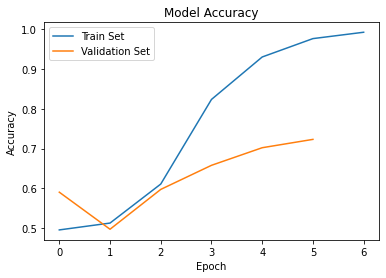

In [23]:
plot.plot(ann_model.history.history['accuracy'])
plot.plot(ann_model.history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Model Loss

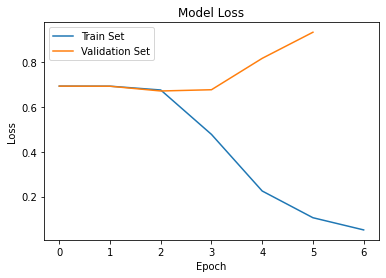

In [24]:
plot.plot(ann_model.history.history['loss'])
plot.plot(ann_model.history.history['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train Set', 'Validation Set'], loc='upper left')
plot.show()

##### Results

In [25]:
print("Validation acc set at\t",ann_model.evaluate(x_Val,y_Val))
print("Test acc set at\t",ann_model.evaluate(x_Test,y_Test))
ann_model_predictions = ann_model.predict(x_Test)
np.unique((ann_model_predictions.round() == y_Test),return_counts=True)

430/430 [==============================] - 1s 3ms/sample - loss: 0.9931 - accuracy: 0.7070
Validation acc set at	 [0.9931369404460109, 0.7069768]
430/430 [==============================] - 1s 3ms/sample - loss: 0.9862 - accuracy: 0.6977
Test acc set at	 [0.9862098178198171, 0.6976744]


(array([False,  True]), array([92450, 92450]))

___ANN Results___


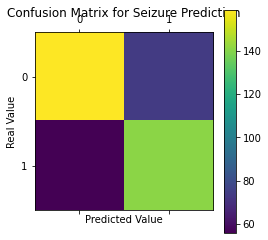

CM
 [[159  74]
 [ 56 141]]

Model Accuracy	:	 69.77%
Sensitivity	:	 71.57%
Specificity	:	 68.24%


In [27]:
print("___ANN Results___")
cm = confusion_matrix(ann_model_predictions.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# ann_model_predictions.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,ann_model_predictions.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)


## Load previous models and use for testing

#### Replicated Tsiouris LSTM

In [18]:
tsiouris_model = tf.keras.models.load_model('models/tsiouris_lstm')
tsiouris_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 128)           11862528  
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 11,998,306
Trainable params: 11,998,306
Non-trainable params: 0
_________________________________________________________________


### Generate predictions on different layer models

In [62]:
# test model, showcasing each model with the first 20 instances of test data
for index,testLabel in enumerate(y_Test[:20]):
    print(index)
    print('True label value\t:\t','preictal' if testLabel == 1 else 'interictal')
    print('1_layer LSTM prediction\t:\t', 'preictal' if _1_layer_model.predict(x_Test[index].reshape(1,12,-1))[0][0].round() == 1 else 'interictal')
    print('2_layer LSTM prediction\t:\t', 'preictal' if _2_layer_model.predict(x_Test[index].reshape(1,12,-1))[0][0].round() == 1 else 'interictal')
    print('3_layer LSTM prediction\t:\t', 'preictal' if _3_layer_model.predict(x_Test[index].reshape(1,12,-1))[0][0].round() == 1 else 'interictal')
    print('Tsiouris LSTM prediction:\t', 'preictal' if tsiouris_model.predict(x_Test[index].reshape(1,12,-1))[0][0].round() == 1 else 'interictal')
    print('next test class\n\n')

0
True label value	:	 interictal
1_layer LSTM prediction	:	 interictal
2_layer LSTM prediction	:	 interictal
3_layer LSTM prediction	:	 interictal
Tsiouris LSTM prediction:	 preictal
next test class


1
True label value	:	 preictal
1_layer LSTM prediction	:	 preictal
2_layer LSTM prediction	:	 preictal
3_layer LSTM prediction	:	 preictal
Tsiouris LSTM prediction:	 interictal
next test class


2
True label value	:	 preictal
1_layer LSTM prediction	:	 preictal
2_layer LSTM prediction	:	 preictal
3_layer LSTM prediction	:	 preictal
Tsiouris LSTM prediction:	 interictal
next test class


3
True label value	:	 interictal
1_layer LSTM prediction	:	 preictal
2_layer LSTM prediction	:	 interictal
3_layer LSTM prediction	:	 interictal
Tsiouris LSTM prediction:	 interictal
next test class


4
True label value	:	 interictal
1_layer LSTM prediction	:	 preictal
2_layer LSTM prediction	:	 preictal
3_layer LSTM prediction	:	 preictal
Tsiouris LSTM prediction:	 interictal
next test class


5
True labe